In [32]:
import torch.nn as nn
import torch
import os
import sys
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import copy
from sklearn.model_selection import KFold

sys.path.append('../')
from utils import BrainGraphDataset, get_data_labels, project_root
from old_models import SimpleFCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 4950
hidden_dim = 128

lr = 1e-3
batch_size = 8
num_epochs = 200

annotations = 'annotations.csv'

parent_dir = project_root()
dataroot = 'fc_matrices/psilo_ica_100_before/'
categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

dataset = BrainGraphDataset(img_dir=os.path.join(parent_dir, dataroot),
                            annotations_file= os.path.join(parent_dir, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

# split the dataset into training and validation sets

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create empty lists to store train and validation loaders
train_loaders = []
val_loaders = []
train_sizes = []
val_sizes = []

torch.manual_seed(0)
for train_index, val_index in kf.split(dataset):
    # Split dataset into train and validation sets for the current fold
    train_set = torch.utils.data.Subset(dataset, train_index)
    val_set = torch.utils.data.Subset(dataset, val_index)

    # Define the dataloaders for the current fold
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Append the loaders to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    train_sizes.append(len(train_set))
    val_sizes.append(len(val_set))

# define a dictionary to store the loss curves for each configuration
loss_curves = {}
dropout_list = [0]

for dropout in dropout_list:
    best_set = [None] * num_folds 
    for t, t_loader in enumerate(train_loaders):
        val_loader = val_loaders[t]
        best_val_loss = float('inf')  # set to infinity to start
        best_model_state = None

        train_losses = []
        val_losses = []
        hidden = [hidden_dim] * 4
        model = SimpleFCNN(input_dim, hidden, dropout=dropout)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            val_loss = 0.0

            # training
            model.train()
            for batch_idx, ((fc, base), label) in enumerate(t_loader):
                fc = fc.to(device)  # move data to device
                base = base.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()

                output = model(fc, base)

                (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
                loss = mae_loss + l2_reg
                loss.backward()
                optimizer.step()
                train_loss += mae_loss.item()

            # validation
            model.eval()
            val_label = []
            val_output = []
            val_base = []
            with torch.no_grad():
                for batch_idx, ((fc, base), label) in enumerate(val_loader):
                    fc = fc.to(device)  # move data to device
                    base = base.to(device)
                    label = label.to(device)

                    output = model(fc, base)
                    
                    val_label.extend(label)
                    val_output.extend(output)
                    val_base.extend(base)
                    

                    (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
                    loss = mae_loss + l2_reg
                    val_loss += mae_loss.item()
            # append losses to lists
            train_losses.append(train_loss/(train_sizes[t]))
            val_losses.append(val_loss/(val_sizes[t]))

            # save the model if the validation loss is at its minimum
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = (copy.deepcopy(model.state_dict()), epoch)
                best_set[t] = (val_label, val_output, val_base)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')



cpu


  5%|▌         | 10/200 [00:14<04:38,  1.46s/it]

Epoch 10/200 - Train Loss: 4.5067 - Val Loss: 12.5833



 10%|█         | 20/200 [00:29<04:22,  1.46s/it]

Epoch 20/200 - Train Loss: 1.7694 - Val Loss: 12.4778



 15%|█▌        | 30/200 [00:43<04:07,  1.46s/it]

Epoch 30/200 - Train Loss: 1.0428 - Val Loss: 12.7644



 20%|██        | 40/200 [00:58<03:54,  1.46s/it]

Epoch 40/200 - Train Loss: 0.9178 - Val Loss: 13.0485



 25%|██▌       | 50/200 [01:12<03:39,  1.46s/it]

Epoch 50/200 - Train Loss: 1.4531 - Val Loss: 13.0854



 30%|███       | 60/200 [01:27<03:25,  1.47s/it]

Epoch 60/200 - Train Loss: 0.7167 - Val Loss: 12.8321



 35%|███▌      | 70/200 [01:41<03:10,  1.47s/it]

Epoch 70/200 - Train Loss: 0.4706 - Val Loss: 13.1277



 40%|████      | 80/200 [01:56<02:56,  1.47s/it]

Epoch 80/200 - Train Loss: 1.1670 - Val Loss: 12.8835



 45%|████▌     | 90/200 [02:11<02:38,  1.44s/it]

Epoch 90/200 - Train Loss: 1.0196 - Val Loss: 12.6756



 50%|█████     | 100/200 [02:25<02:25,  1.46s/it]

Epoch 100/200 - Train Loss: 1.0005 - Val Loss: 13.3080



 55%|█████▌    | 110/200 [02:40<02:09,  1.44s/it]

Epoch 110/200 - Train Loss: 0.7603 - Val Loss: 13.4430



 60%|██████    | 120/200 [02:55<02:04,  1.56s/it]

Epoch 120/200 - Train Loss: 1.6356 - Val Loss: 13.4889



 65%|██████▌   | 130/200 [03:11<01:49,  1.56s/it]

Epoch 130/200 - Train Loss: 0.7930 - Val Loss: 12.5894



 70%|███████   | 140/200 [03:26<01:28,  1.47s/it]

Epoch 140/200 - Train Loss: 0.6640 - Val Loss: 12.3431



 75%|███████▌  | 150/200 [03:40<01:13,  1.48s/it]

Epoch 150/200 - Train Loss: 1.8828 - Val Loss: 13.4273



 80%|████████  | 160/200 [03:55<00:59,  1.48s/it]

Epoch 160/200 - Train Loss: 1.3501 - Val Loss: 12.8961



 85%|████████▌ | 170/200 [04:10<00:44,  1.47s/it]

Epoch 170/200 - Train Loss: 1.1700 - Val Loss: 12.3754



 90%|█████████ | 180/200 [04:24<00:29,  1.46s/it]

Epoch 180/200 - Train Loss: 0.9116 - Val Loss: 13.0041



 95%|█████████▌| 190/200 [04:39<00:14,  1.46s/it]

Epoch 190/200 - Train Loss: 0.3612 - Val Loss: 13.1113



100%|██████████| 200/200 [04:54<00:00,  1.47s/it]


Epoch 200/200 - Train Loss: 0.7784 - Val Loss: 13.6545



  5%|▌         | 10/200 [00:14<04:38,  1.47s/it]

Epoch 10/200 - Train Loss: 4.7381 - Val Loss: 6.2136



 10%|█         | 20/200 [00:29<04:21,  1.45s/it]

Epoch 20/200 - Train Loss: 3.5117 - Val Loss: 7.0256



 15%|█▌        | 30/200 [00:43<04:07,  1.46s/it]

Epoch 30/200 - Train Loss: 2.0561 - Val Loss: 7.4166



 20%|██        | 40/200 [00:58<03:54,  1.46s/it]

Epoch 40/200 - Train Loss: 0.4833 - Val Loss: 7.5027



 25%|██▌       | 50/200 [01:13<03:44,  1.50s/it]

Epoch 50/200 - Train Loss: 1.1511 - Val Loss: 7.9625



 30%|███       | 60/200 [01:28<03:31,  1.51s/it]

Epoch 60/200 - Train Loss: 4.2205 - Val Loss: 6.8431



 35%|███▌      | 70/200 [01:43<03:13,  1.49s/it]

Epoch 70/200 - Train Loss: 0.7728 - Val Loss: 7.2568



 40%|████      | 80/200 [01:58<02:57,  1.48s/it]

Epoch 80/200 - Train Loss: 1.1940 - Val Loss: 8.2873



 45%|████▌     | 90/200 [02:12<02:44,  1.49s/it]

Epoch 90/200 - Train Loss: 1.1973 - Val Loss: 7.2355



 50%|█████     | 100/200 [02:27<02:29,  1.49s/it]

Epoch 100/200 - Train Loss: 1.0063 - Val Loss: 7.8979



 55%|█████▌    | 110/200 [02:42<02:14,  1.49s/it]

Epoch 110/200 - Train Loss: 2.1722 - Val Loss: 7.6091



 60%|██████    | 120/200 [02:57<01:58,  1.48s/it]

Epoch 120/200 - Train Loss: 1.9860 - Val Loss: 7.3812



 65%|██████▌   | 130/200 [03:12<01:43,  1.47s/it]

Epoch 130/200 - Train Loss: 0.5064 - Val Loss: 7.8277



 70%|███████   | 140/200 [03:27<01:27,  1.46s/it]

Epoch 140/200 - Train Loss: 1.1986 - Val Loss: 8.2303



 75%|███████▌  | 150/200 [03:41<01:12,  1.45s/it]

Epoch 150/200 - Train Loss: 0.8780 - Val Loss: 7.3101



 80%|████████  | 160/200 [03:56<00:58,  1.46s/it]

Epoch 160/200 - Train Loss: 1.3171 - Val Loss: 7.1278



 85%|████████▌ | 170/200 [04:10<00:43,  1.46s/it]

Epoch 170/200 - Train Loss: 0.6923 - Val Loss: 7.6156



 90%|█████████ | 180/200 [04:25<00:29,  1.45s/it]

Epoch 180/200 - Train Loss: 1.4073 - Val Loss: 8.3824



 95%|█████████▌| 190/200 [04:39<00:14,  1.46s/it]

Epoch 190/200 - Train Loss: 0.7532 - Val Loss: 7.2425



100%|██████████| 200/200 [04:54<00:00,  1.47s/it]


Epoch 200/200 - Train Loss: 0.5978 - Val Loss: 8.0770



  5%|▌         | 10/200 [00:14<04:38,  1.46s/it]

Epoch 10/200 - Train Loss: 5.5456 - Val Loss: 6.6137



 10%|█         | 20/200 [00:29<04:26,  1.48s/it]

Epoch 20/200 - Train Loss: 2.4031 - Val Loss: 7.0691



 15%|█▌        | 30/200 [00:44<04:12,  1.49s/it]

Epoch 30/200 - Train Loss: 1.1204 - Val Loss: 6.6781



 20%|██        | 40/200 [00:59<03:57,  1.48s/it]

Epoch 40/200 - Train Loss: 1.8365 - Val Loss: 7.1759



 25%|██▌       | 50/200 [01:13<03:38,  1.46s/it]

Epoch 50/200 - Train Loss: 1.1348 - Val Loss: 6.7422



 30%|███       | 60/200 [01:28<03:24,  1.46s/it]

Epoch 60/200 - Train Loss: 1.2520 - Val Loss: 6.6036



 35%|███▌      | 70/200 [01:42<03:09,  1.46s/it]

Epoch 70/200 - Train Loss: 0.8037 - Val Loss: 6.9394



 40%|████      | 80/200 [01:57<02:57,  1.48s/it]

Epoch 80/200 - Train Loss: 0.5938 - Val Loss: 6.6648



 45%|████▌     | 90/200 [02:12<02:43,  1.49s/it]

Epoch 90/200 - Train Loss: 2.5596 - Val Loss: 8.0984



 50%|█████     | 100/200 [02:26<02:26,  1.47s/it]

Epoch 100/200 - Train Loss: 0.7453 - Val Loss: 6.8091



 55%|█████▌    | 110/200 [02:41<02:13,  1.48s/it]

Epoch 110/200 - Train Loss: 1.1223 - Val Loss: 6.5306



 60%|██████    | 120/200 [02:56<01:58,  1.49s/it]

Epoch 120/200 - Train Loss: 1.1497 - Val Loss: 7.2957



 65%|██████▌   | 130/200 [03:11<01:43,  1.49s/it]

Epoch 130/200 - Train Loss: 0.7009 - Val Loss: 6.7652



 70%|███████   | 140/200 [03:26<01:28,  1.48s/it]

Epoch 140/200 - Train Loss: 0.9110 - Val Loss: 6.5464



 75%|███████▌  | 150/200 [03:41<01:14,  1.49s/it]

Epoch 150/200 - Train Loss: 0.4437 - Val Loss: 7.0086



 80%|████████  | 160/200 [03:55<00:58,  1.46s/it]

Epoch 160/200 - Train Loss: 1.2283 - Val Loss: 7.7896



 85%|████████▌ | 170/200 [04:10<00:44,  1.47s/it]

Epoch 170/200 - Train Loss: 0.9415 - Val Loss: 6.7209



 90%|█████████ | 180/200 [04:25<00:29,  1.46s/it]

Epoch 180/200 - Train Loss: 1.2897 - Val Loss: 6.6691



 95%|█████████▌| 190/200 [04:39<00:14,  1.46s/it]

Epoch 190/200 - Train Loss: 0.8028 - Val Loss: 6.7972



100%|██████████| 200/200 [04:54<00:00,  1.47s/it]


Epoch 200/200 - Train Loss: 0.9082 - Val Loss: 6.7038



  5%|▌         | 10/200 [00:14<04:40,  1.48s/it]

Epoch 10/200 - Train Loss: 4.5280 - Val Loss: 8.2550



 10%|█         | 20/200 [00:29<04:24,  1.47s/it]

Epoch 20/200 - Train Loss: 2.1373 - Val Loss: 7.9748



 15%|█▌        | 30/200 [00:44<04:08,  1.46s/it]

Epoch 30/200 - Train Loss: 0.8715 - Val Loss: 7.7454



 20%|██        | 40/200 [00:58<03:58,  1.49s/it]

Epoch 40/200 - Train Loss: 1.4423 - Val Loss: 7.7020



 25%|██▌       | 50/200 [01:13<03:45,  1.50s/it]

Epoch 50/200 - Train Loss: 0.9517 - Val Loss: 7.3953



 30%|███       | 60/200 [01:28<03:29,  1.50s/it]

Epoch 60/200 - Train Loss: 0.7525 - Val Loss: 7.5583



 35%|███▌      | 70/200 [01:43<03:13,  1.49s/it]

Epoch 70/200 - Train Loss: 1.3118 - Val Loss: 7.6351



 40%|████      | 80/200 [01:58<02:58,  1.49s/it]

Epoch 80/200 - Train Loss: 1.0752 - Val Loss: 7.8110



 45%|████▌     | 90/200 [02:13<02:42,  1.48s/it]

Epoch 90/200 - Train Loss: 1.0612 - Val Loss: 7.5417



 50%|█████     | 100/200 [02:28<02:29,  1.50s/it]

Epoch 100/200 - Train Loss: 0.7788 - Val Loss: 7.4531



 55%|█████▌    | 110/200 [02:43<02:13,  1.49s/it]

Epoch 110/200 - Train Loss: 1.3482 - Val Loss: 7.3707



 60%|██████    | 120/200 [02:58<01:59,  1.50s/it]

Epoch 120/200 - Train Loss: 1.0889 - Val Loss: 7.6205



 65%|██████▌   | 130/200 [03:13<01:43,  1.48s/it]

Epoch 130/200 - Train Loss: 0.8507 - Val Loss: 7.2791



 70%|███████   | 140/200 [03:27<01:30,  1.50s/it]

Epoch 140/200 - Train Loss: 1.4485 - Val Loss: 7.6856



 75%|███████▌  | 150/200 [03:42<01:15,  1.51s/it]

Epoch 150/200 - Train Loss: 0.6285 - Val Loss: 7.6573



 80%|████████  | 160/200 [03:57<00:59,  1.49s/it]

Epoch 160/200 - Train Loss: 1.2093 - Val Loss: 7.6064



 85%|████████▌ | 170/200 [04:12<00:43,  1.46s/it]

Epoch 170/200 - Train Loss: 1.5000 - Val Loss: 7.4334



 90%|█████████ | 180/200 [04:26<00:28,  1.45s/it]

Epoch 180/200 - Train Loss: 1.0203 - Val Loss: 7.6777



 95%|█████████▌| 190/200 [04:41<00:14,  1.47s/it]

Epoch 190/200 - Train Loss: 1.2424 - Val Loss: 7.2656



100%|██████████| 200/200 [04:56<00:00,  1.48s/it]


Epoch 200/200 - Train Loss: 1.3677 - Val Loss: 7.2116



  5%|▌         | 10/200 [00:14<04:42,  1.49s/it]

Epoch 10/200 - Train Loss: 5.4061 - Val Loss: 6.9765



 10%|█         | 20/200 [00:29<04:24,  1.47s/it]

Epoch 20/200 - Train Loss: 1.7664 - Val Loss: 8.6125



 15%|█▌        | 30/200 [00:45<04:27,  1.57s/it]

Epoch 30/200 - Train Loss: 1.3677 - Val Loss: 8.2047



 20%|██        | 40/200 [01:00<03:58,  1.49s/it]

Epoch 40/200 - Train Loss: 0.6402 - Val Loss: 8.0090



 25%|██▌       | 50/200 [01:14<03:37,  1.45s/it]

Epoch 50/200 - Train Loss: 1.1575 - Val Loss: 8.2675



 30%|███       | 60/200 [01:29<03:24,  1.46s/it]

Epoch 60/200 - Train Loss: 0.8342 - Val Loss: 8.2241



 35%|███▌      | 70/200 [01:44<03:11,  1.48s/it]

Epoch 70/200 - Train Loss: 0.7863 - Val Loss: 8.1856



 40%|████      | 80/200 [01:59<02:59,  1.50s/it]

Epoch 80/200 - Train Loss: 1.5483 - Val Loss: 8.3054



 45%|████▌     | 90/200 [02:13<02:44,  1.49s/it]

Epoch 90/200 - Train Loss: 0.5495 - Val Loss: 8.0186



 50%|█████     | 100/200 [02:28<02:27,  1.48s/it]

Epoch 100/200 - Train Loss: 1.4032 - Val Loss: 8.3494



 55%|█████▌    | 110/200 [02:43<02:14,  1.49s/it]

Epoch 110/200 - Train Loss: 0.7611 - Val Loss: 8.1169



 60%|██████    | 120/200 [02:58<01:59,  1.49s/it]

Epoch 120/200 - Train Loss: 0.5928 - Val Loss: 7.9817



 65%|██████▌   | 130/200 [03:13<01:45,  1.51s/it]

Epoch 130/200 - Train Loss: 0.7318 - Val Loss: 8.1342



 70%|███████   | 140/200 [03:28<01:30,  1.50s/it]

Epoch 140/200 - Train Loss: 0.6675 - Val Loss: 8.0848



 75%|███████▌  | 150/200 [03:43<01:14,  1.50s/it]

Epoch 150/200 - Train Loss: 2.6704 - Val Loss: 7.6689



 80%|████████  | 160/200 [03:58<00:59,  1.50s/it]

Epoch 160/200 - Train Loss: 1.7157 - Val Loss: 8.2978



 85%|████████▌ | 170/200 [04:13<00:44,  1.48s/it]

Epoch 170/200 - Train Loss: 0.6547 - Val Loss: 8.1557



 90%|█████████ | 180/200 [04:28<00:29,  1.46s/it]

Epoch 180/200 - Train Loss: 1.6812 - Val Loss: 8.0623



 95%|█████████▌| 190/200 [04:42<00:14,  1.45s/it]

Epoch 190/200 - Train Loss: 1.3994 - Val Loss: 7.9799



100%|██████████| 200/200 [04:57<00:00,  1.49s/it]

Epoch 200/200 - Train Loss: 0.7530 - Val Loss: 8.3826



-0.07703183698388716
PearsonRResult(statistic=0.1418763779678292, pvalue=0.37011315216803076)
7.29473953020005



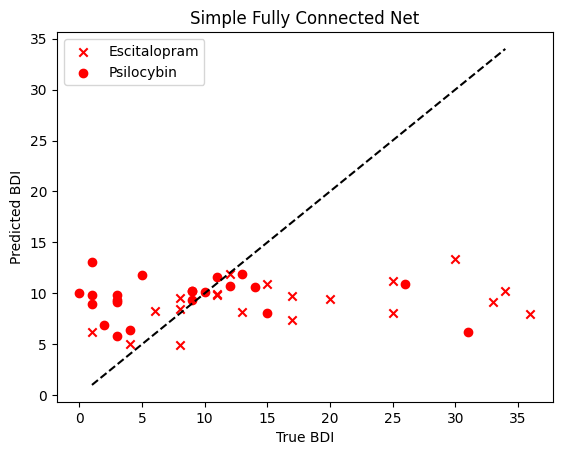

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error

r2_scores = []
mae_scores = []
r_scores = []

l1 = []
l2 = []

for fold in best_set:
    l1.extend([t.item() for t in fold[0]])
    l2.extend([t.item() for t in fold[1]])
    
print(r2_score(l1, l2))
print(pearsonr(l1, l2))
print(mean_absolute_error(l1,l2))

print()

total_true = []
total_pred = []
total_drug = []
total_base = []

for i, (true, pred, base) in enumerate(best_set):
    true = [t.item() for t in true]
    pred = [p.item() for p in pred]
    drug = [d[0].item() for d in base]
    base = [d[1].item() for d in base]
    
    total_true.extend(true)
    total_pred.extend(pred)
    total_drug.extend(drug)
    total_base.extend(base)
    # Calculate R-squared (Pearson correlation coefficient)
    r2 = r2_score(true, pred)
    r2_scores.append(r2)

    r_scores.append(pearsonr(true, pred))
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, pred)
    mae_scores.append(mae)
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)

min_val = min(min(true), min(pred))
max_val = max(max(true), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        
plt.xlabel('True BDI')
plt.ylabel('Predicted BDI')
plt.title('Simple Fully Connected Net')
plt.legend(['Escitalopram', 'Psilocybin'])
plt.savefig('simple_fc_net.png', bbox_inches='tight')
plt.show()

# Calculate average R-squared and MAE across all folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)

import csv
head = ['r2', 'pearson_r', 'pval']
with open('use_nf.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(head)

    # Write the data rows
    for i in range(5):
        writer.writerow([r2_scores[i], r_scores[i][0], r_scores[i][1]])
        
# Specify the filename for the CSV file
filename = 'simple-fc-net.csv'

# Create a list of rows with headers
rows = [['true_post_bdi', 'predicted_post_bdi', 'drug (1 for psilo)', 'base_bdi']]
for true, pred, drug, base in zip(total_true, total_pred, total_drug, total_base):
    rows.append([true, pred, drug, base]) 

# Write the rows to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)